In [1]:
pip install pycaret xgboost lightgbm catboost shap

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Cell 1 — Load Ames Housing data & sanity checks

import os
import pandas as pd
import numpy as np

# -----------------------------
# Paths (assumes files are in the current working directory)
# -----------------------------
TRAIN_PATH = "/Users/spartan/Documents/GitHub/Pycaret_Assignment/Regression/dataset/train.csv"
TEST_PATH = "/Users/spartan/Documents/GitHub/Pycaret_Assignment/Regression/dataset/test.csv"
SAMPLE_SUB_PATH = "/Users/spartan/Documents/GitHub/Pycaret_Assignment/Regression/dataset/sample_submission.csv"
DATA_DESC_PATH = "/Users/spartan/Documents/GitHub/Pycaret_Assignment/Regression/dataset/data_description.txt"  # optional

# -----------------------------
# Load
# -----------------------------
assert os.path.exists(TRAIN_PATH), f"Missing {TRAIN_PATH}"
assert os.path.exists(TEST_PATH), f"Missing {TEST_PATH}"

train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

# -----------------------------
# Basic info
# -----------------------------
print("Train shape:", train.shape)
print("Test shape :", test.shape)
print("\nTrain columns (first 10):", list(train.columns[:10]))
print("\nTarget column expected: 'SalePrice'")
print("ID column expected     : 'Id'")

# -----------------------------
# Sanity checks
# -----------------------------
expected_target = "SalePrice"
id_col = "Id"

# 1) Target existence & NA check
assert expected_target in train.columns, f"Target '{expected_target}' not found in train."
print(f"\nMissing values in target ({expected_target}):", train[expected_target].isna().sum())

# 2) Ensure test set does not contain target
if expected_target in test.columns:
    print("Warning: 'SalePrice' found in test.csv; dropping it to mimic blind test.")
    test = test.drop(columns=[expected_target])

# 3) ID column checks
for df_name, df in [("train", train), ("test", test)]:
    assert id_col in df.columns, f"'{id_col}' not found in {df_name}."
    dup_ids = df[id_col].duplicated().sum()
    print(f"Duplicate {id_col} in {df_name}: {dup_ids}")

# 4) Column overlap between train and test (excluding target)
train_features = set(train.columns) - {expected_target}
test_features = set(test.columns)
missing_in_test = sorted(list(train_features - test_features))
extra_in_test = sorted(list(test_features - train_features))
print("\nFeatures missing in test (w.r.t. train):", missing_in_test)
print("Extra features in test (w.r.t. train)   :", extra_in_test)

# -----------------------------
# Quick peek
# -----------------------------
display(train.head(3))
display(test.head(3))

# -----------------------------
# Missing values summary (top 20 by count)
# -----------------------------
def missing_summary(df, name):
    ms = df.isna().sum().sort_values(ascending=False)
    ms = ms[ms > 0].to_frame(name="missing").assign(pct=lambda x: 100 * x["missing"] / len(df))
    print(f"\nTop missing values in {name}:")
    display(ms.head(20))

missing_summary(train, "train")
missing_summary(test, "test")

# -----------------------------
# Basic target stats
# -----------------------------
print("\nTarget (SalePrice) summary:")
display(train["SalePrice"].describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]).to_frame().T)

# Optional: keep only columns shared by train/test + target (PyCaret handles dtypes automatically)
# We'll keep all columns for now; PyCaret will manage encoding/imputation.
# Next cell: PyCaret setup() mirroring your original workflow.


Train shape: (1460, 81)
Test shape : (1459, 80)

Train columns (first 10): ['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities']

Target column expected: 'SalePrice'
ID column expected     : 'Id'

Missing values in target (SalePrice): 0
Duplicate Id in train: 0
Duplicate Id in test: 0

Features missing in test (w.r.t. train): []
Extra features in test (w.r.t. train)   : []


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal



Top missing values in train:


,missing,pct
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
MasVnrType,872,59.726027
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageYrBlt,81,5.547945
GarageCond,81,5.547945
GarageType,81,5.547945



Top missing values in test:


,missing,pct
PoolQC,1456,99.794380
MiscFeature,1408,96.504455
Alley,1352,92.666210
Fence,1169,80.123372
MasVnrType,894,61.274846
FireplaceQu,730,50.034270
LotFrontage,227,15.558602
GarageYrBlt,78,5.346127
GarageQual,78,5.346127
GarageFinish,78,5.346127



Target (SalePrice) summary:


,count,mean,std,min,1%,5%,50%,95%,99%,max
SalePrice,1460.0,180921.19589,79442.502883,34900.0,61815.97,88000.0,163000.0,326100.0,442567.01,755000.0


In [3]:
# Cell 2 — PyCaret setup (Regression)

from pycaret.regression import *

TARGET = "SalePrice"
ID_COL = "Id"

# Environment-aware: ignore the ID column; keep everything else
# Reproducible folds via session_id. Imputation kept simple & fast.
s = setup(
    data=train,
    target=TARGET,
    ignore_features=[ID_COL],
    fold=5,
    session_id=42,
    numeric_imputation="median",
    categorical_imputation="mode",
    normalize=False,                 # keep raw scale (we can toggle later if needed)
    remove_multicollinearity=False,  # leave features as-is (Ames has many correlated cols; we'll compare models fairly)
    log_experiment=False,            # turn on if you want MLflow logging
    verbose=True
)

print("\n✅ PyCaret setup complete.")

# (Optional) Peek at available estimators so we only 'include' installed ones later
avail = models()  # table of available models in this environment
display(avail)


,Description,Value
0,Session id,42
1,Target,SalePrice
2,Target type,Regression
3,Original data shape,"(1460, 81)"
4,Transformed data shape,"(1460, 279)"
5,Transformed train set shape,"(1021, 279)"
6,Transformed test set shape,"(439, 279)"
7,Ignore features,1
8,Numeric features,36
9,Categorical features,43



✅ PyCaret setup complete.


,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


In [4]:
# Cell 3 — Compare candidate models (environment-aware)

from pycaret.regression import models, compare_models, pull

# Build an include list based on what's actually installed/available
avail_df = models()
try:
    avail_ids = set(avail_df.index.astype(str))
except Exception:
    # Fallback if the API changes
    avail_ids = set(avail_df["ID"].astype(str))

candidates = [
    # Linear family
    "lr", "ridge", "lasso", "en", "huber", "omp", "br", "lar", "llar", "par", "ransac",
    # KNN
    "knn",
    # Trees & ensembles
    "dt", "rf", "et", "gbr",
    # Boosters (optional deps)
    "lightgbm", "xgboost", "catboost",
]

include = [m for m in candidates if m in avail_ids]
skipped = [m for m in candidates if m not in avail_ids]

print("Included models:", include)
if skipped:
    print("Skipped (not available in this environment):", skipped)

# Compare using MAE (more robust to outliers than RMSE)
best = compare_models(include=include or None, sort="MAE")
print("\n✅ Model comparison complete. Best model object:")
print(best)

# Show the leaderboard table
display(pull())



Included models: ['lr', 'ridge', 'lasso', 'en', 'huber', 'omp', 'br', 'lar', 'llar', 'par', 'ransac', 'knn', 'dt', 'rf', 'et', 'gbr', 'lightgbm', 'xgboost', 'catboost']


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,15603.4444,952221056.2300,29916.7051,0.8457,0.1307,0.0879,0.6480
lightgbm,Light Gradient Boosting Machine,17534.2704,1019915368.9294,31188.6587,0.8346,0.1423,0.0996,0.3420
gbr,Gradient Boosting Regressor,17627.3244,1184193297.8941,32738.6272,0.8080,0.1427,0.0996,0.1120
rf,Random Forest Regressor,18818.5868,1159149938.1850,33064.7084,0.8109,0.1530,0.1088,0.1620
et,Extra Trees Regressor,19249.9616,1175032837.9470,33537.6215,0.8077,0.1565,0.1118,0.1600
ridge,Ridge Regression,19459.6281,1440650735.4606,35619.5452,0.7670,0.1709,0.1151,0.3520
xgboost,Extreme Gradient Boosting,19665.4793,1564996611.6679,37517.3025,0.7470,0.1561,0.1097,0.0900
lasso,Lasso Regression,20018.4993,1830445144.0583,40856.7672,0.6909,0.2072,0.1179,0.4620
en,Elastic Net,20161.9921,1686676118.1254,38150.2825,0.7296,0.1757,0.1152,0.0840
llar,Lasso Least Angle Regression,20812.2301,2031249845.8056,42067.0790,0.6521,0.1584,0.1193,0.0580



✅ Model comparison complete. Best model object:


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,1.560344e+04,9.522211e+08,2.991671e+04,8.457000e-01,0.1307,8.790000e-02,0.648
lightgbm,Light Gradient Boosting Machine,1.753427e+04,1.019915e+09,3.118866e+04,8.346000e-01,0.1423,9.960000e-02,0.342
gbr,Gradient Boosting Regressor,1.762732e+04,1.184193e+09,3.273863e+04,8.080000e-01,0.1427,9.960000e-02,0.112
rf,Random Forest Regressor,1.881859e+04,1.159150e+09,3.306471e+04,8.109000e-01,0.1530,1.088000e-01,0.162
et,Extra Trees Regressor,1.924996e+04,1.175033e+09,3.353762e+04,8.077000e-01,0.1565,1.118000e-01,0.160
ridge,Ridge Regression,1.945963e+04,1.440651e+09,3.561955e+04,7.670000e-01,0.1709,1.151000e-01,0.352
xgboost,Extreme Gradient Boosting,1.966548e+04,1.564997e+09,3.751730e+04,7.470000e-01,0.1561,1.097000e-01,0.090
lasso,Lasso Regression,2.001850e+04,1.830445e+09,4.085677e+04,6.909000e-01,0.2072,1.179000e-01,0.462
en,Elastic Net,2.016199e+04,1.686676e+09,3.815028e+04,7.296000e-01,0.1757,1.152000e-01,0.084
llar,Lasso Least Angle Regression,2.081223e+04,2.031250e+09,4.206708e+04,6.521000e-01,0.1584,1.193000e-01,0.058


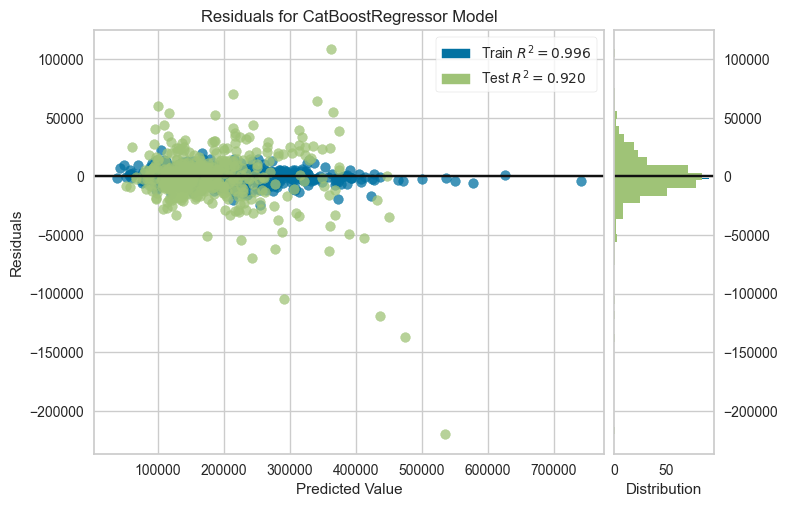

✅ Residuals plot done.


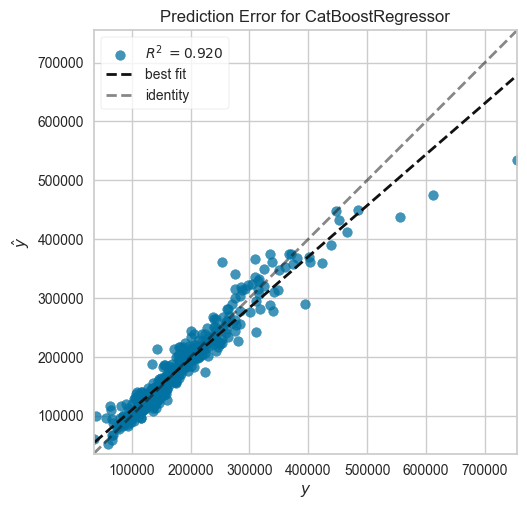

✅ Error plot done.


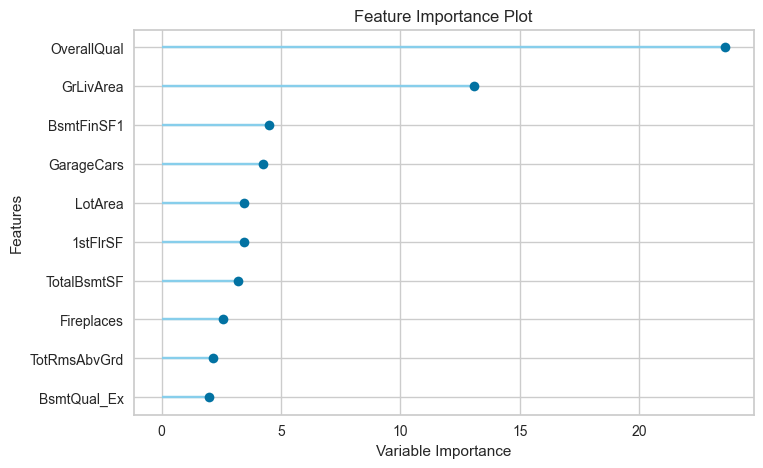

✅ Feature importance plot done.


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,14288.7561,555616257.3236,23571.5137,0.9202,0.1205,0.0840



Holdout evaluation snapshot:


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,14288.7561,5.556163e+08,23571.5137,0.9202,0.1205,0.084


In [5]:
# Cell 4 — Baseline model diagnostics & plots

from pycaret.regression import plot_model, predict_model, pull

# 1) Residuals plot
try:
    plot_model(best, plot="residuals")
    print("✅ Residuals plot done.")
except Exception as e:
    print("Residuals plot not available for this estimator:", e)

# 2) Error plot (Prediction Error)
try:
    plot_model(best, plot="error")
    print("✅ Error plot done.")
except Exception as e:
    print("Error plot not available for this estimator:", e)

# 3) Feature importance (may not be supported for some models)
try:
    plot_model(best, plot="feature")
    print("✅ Feature importance plot done.")
except Exception as e:
    print("Feature importance not available for this estimator:", e)

# 4) Holdout predictions & metrics snapshot
_ = predict_model(best)   # evaluates on holdout/validation set inside PyCaret
leaderboard_snapshot = pull()  # pull last displayed table (predictions summary/metrics)
print("\nHoldout evaluation snapshot:")
display(leaderboard_snapshot.head(10))


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,16134.9939,1107760152.9996,33283.0310,0.8381,0.1229,0.0856
1,19393.4125,1446394870.9965,38031.4984,0.7741,0.1629,0.1104
2,17185.8119,1030852185.9815,32106.8869,0.8386,0.1535,0.1016
3,17225.3703,706139399.9656,26573.2836,0.8673,0.1280,0.0943
4,15194.5545,694397861.2488,26351.4300,0.8635,0.1206,0.0818
Mean,17026.8286,997108894.2384,31269.2260,0.8363,0.1376,0.0947
Std,1401.2859,279834742.5913,4398.2271,0.0334,0.0173,0.0104


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).

✅ Tuning complete. Tuned model object:


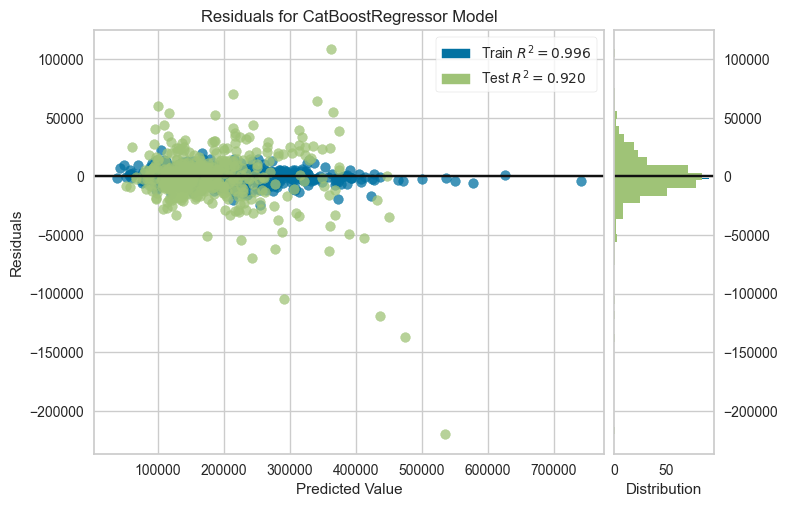

✅ Residuals plot (tuned) done.


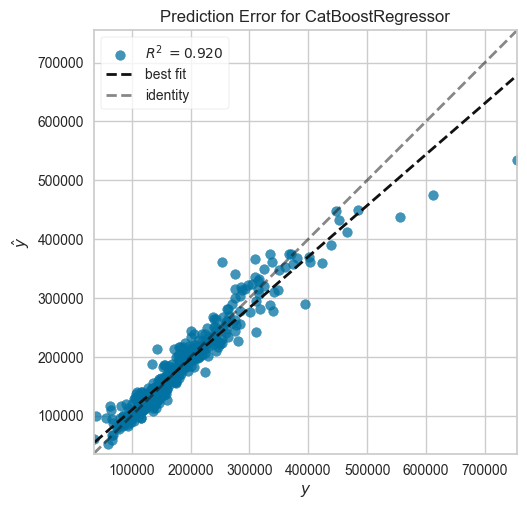

✅ Error plot (tuned) done.


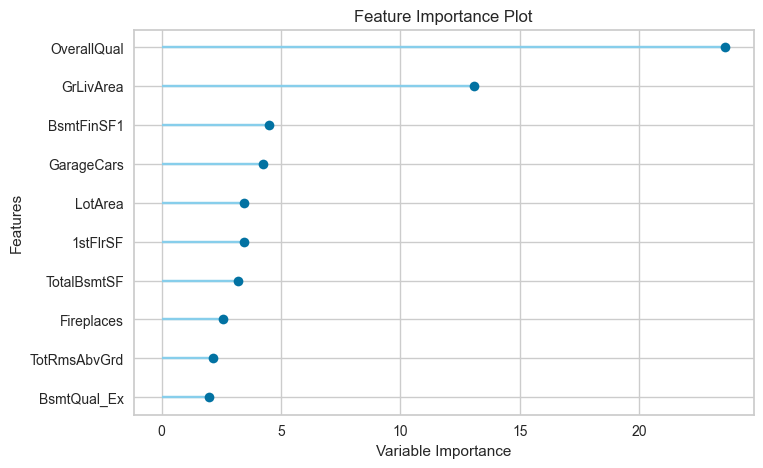

✅ Feature importance (tuned) done.


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,14288.7561,555616257.3236,23571.5137,0.9202,0.1205,0.0840



Holdout evaluation (tuned) snapshot:


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,14288.7561,5.556163e+08,23571.5137,0.9202,0.1205,0.084


In [6]:
# Cell 5 — Hyperparameter tuning of best model

from pycaret.regression import tune_model, plot_model, predict_model, pull

# Tune the selected 'best' model from compare_models()
# Optimize for MAE (mirrors the earlier choice)
tuned_best = tune_model(best, optimize="MAE", choose_better=True, n_iter=50)

print("\n✅ Tuning complete. Tuned model object:")
print(tuned_best)

# 1) Residuals for tuned model
try:
    plot_model(tuned_best, plot="residuals")
    print("✅ Residuals plot (tuned) done.")
except Exception as e:
    print("Residuals plot not available for tuned estimator:", e)

# 2) Error (Prediction Error) plot
try:
    plot_model(tuned_best, plot="error")
    print("✅ Error plot (tuned) done.")
except Exception as e:
    print("Error plot not available for tuned estimator:", e)

# 3) Feature importance (if supported)
try:
    plot_model(tuned_best, plot="feature")
    print("✅ Feature importance (tuned) done.")
except Exception as e:
    print("Feature importance not available for tuned estimator:", e)

# Evaluate tuned model on holdout
_ = predict_model(tuned_best)
tuned_snapshot = pull()
print("\nHoldout evaluation (tuned) snapshot:")
display(tuned_snapshot.head(10))


In [7]:
# Cell 6 — Ensembling, Blending, and Stacking

from pycaret.regression import (
    compare_models, ensemble_model, blend_models, stack_models,
    predict_model, pull, create_model
)

# Re-select a small cohort of strong base models for ensembles
top_models = compare_models(n_select=5, sort="MAE")
print("\nTop models selected for ensembles:")
for i, m in enumerate(top_models, 1):
    print(f"{i}. {m}")

# 1) Bagging (on the tuned best model if possible; else on top_models[0])
bag_base = locals().get("tuned_best", None) or top_models[0]
try:
    bagged = ensemble_model(bag_base, method="Bagging")
    print("\n✅ Bagging created.")
    _ = predict_model(bagged)
    bagged_metrics = pull()
    print("Bagged model holdout metrics:")
    display(bagged_metrics.head(10))
except Exception as e:
    print("Bagging not available for this estimator:", e)
    bagged = None

# 2) Boosting (on the tuned best model if possible; else on top_models[0])
# Note: This uses PyCaret's generic boosting wrapper, not LightGBM/XGB directly.
try:
    boosted = ensemble_model(bag_base, method="Boosting")
    print("\n✅ Boosting created.")
    _ = predict_model(boosted)
    boosted_metrics = pull()
    print("Boosted model holdout metrics:")
    display(boosted_metrics.head(10))
except Exception as e:
    print("Boosting not available for this estimator:", e)
    boosted = None

# 3) Blending (soft voting / weighted average of predictions)
# Use up to 3–4 of the top models for a compact blend
blend_candidates = top_models[:4]
try:
    blender = blend_models(estimator_list=blend_candidates, optimize="MAE")
    print("\n✅ Blended model created.")
    _ = predict_model(blender)
    blend_metrics = pull()
    print("Blended model holdout metrics:")
    display(blend_metrics.head(10))
except Exception as e:
    print("Blending failed:", e)
    blender = None

# 4) Stacking (meta-learner on top of base models)
# Choose a simple, well-behaved meta-learner (ridge) if available; else default
try:
    try:
        meta_learner = create_model("ridge")
    except Exception:
        meta_learner = None

    stacker = stack_models(
        estimator_list=top_models,
        meta_model=meta_learner,
        optimize="MAE",
        fold=5,
        restack=True
    )
    print("\n✅ Stacked model created.")
    _ = predict_model(stacker)
    stack_metrics = pull()
    print("Stacked model holdout metrics:")
    display(stack_metrics.head(10))
except Exception as e:
    print("Stacking failed:", e)
    stacker = None

# 5) Pick the current overall best among tuned/ensembled variants based on MAE
candidates = []
names = []

if "tuned_best" in globals() and tuned_best is not None:
    _ = predict_model(tuned_best)
    candidates.append(pull().assign(Model="tuned_best").head(1))
if bagged is not None:
    _ = predict_model(bagged)
    candidates.append(pull().assign(Model="bagged").head(1))
if boosted is not None:
    _ = predict_model(boosted)
    candidates.append(pull().assign(Model="boosted").head(1))
if blender is not None:
    _ = predict_model(blender)
    candidates.append(pull().assign(Model="blender").head(1))
if stacker is not None:
    _ = predict_model(stacker)
    candidates.append(pull().assign(Model="stacker").head(1))

if candidates:
    import pandas as pd
    summary = pd.concat(candidates, ignore_index=True)
    # Try to locate MAE column robustly
    mae_col = next((c for c in summary.columns if c.upper() == "MAE"), None)
    if mae_col:
        summary_sorted = summary.sort_values(by=mae_col, ascending=True)
    else:
        # Fallback to RMSLE/RMSE if MAE is absent
        alt = next((c for c in summary.columns if c.upper() in ("RMSE", "RMSLE", "MAPE")), None)
        summary_sorted = summary.sort_values(by=alt, ascending=True) if alt else summary

    print("\n🔎 Comparison of tuned/ensembled variants (lower is better):")
    display(summary_sorted)

    # Keep a handle to the current champion
    champion_name = summary_sorted.iloc[0].get("Model", "tuned_best")
    champion = {
        "tuned_best": locals().get("tuned_best"),
        "bagged": bagged,
        "boosted": boosted,
        "blender": locals().get("blender"),
        "stacker": locals().get("stacker")
    }.get(champion_name, locals().get("tuned_best"))

    print(f"\n🏆 Current champion selected: {champion_name}")
else:
    champion = locals().get("tuned_best", None)
    print("\nNo ensemble/blend/stack metrics available; falling back to tuned_best as champion.")


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,15603.4444,952221056.2300,29916.7051,0.8457,0.1307,0.0879,0.5780
lightgbm,Light Gradient Boosting Machine,17534.2704,1019915368.9294,31188.6587,0.8346,0.1423,0.0996,0.3260
gbr,Gradient Boosting Regressor,17627.3244,1184193297.8941,32738.6272,0.8080,0.1427,0.0996,0.1100
rf,Random Forest Regressor,18818.5868,1159149938.1850,33064.7084,0.8109,0.1530,0.1088,0.1600
et,Extra Trees Regressor,19249.9616,1175032837.9470,33537.6215,0.8077,0.1565,0.1118,0.1560
ridge,Ridge Regression,19459.6281,1440650735.4606,35619.5452,0.7670,0.1709,0.1151,0.0500
xgboost,Extreme Gradient Boosting,19665.4793,1564996611.6679,37517.3025,0.7470,0.1561,0.1097,0.0860
lasso,Lasso Regression,20018.4993,1830445144.0583,40856.7672,0.6909,0.2072,0.1179,0.0940
en,Elastic Net,20161.9921,1686676118.1254,38150.2825,0.7296,0.1757,0.1152,0.0880
llar,Lasso Least Angle Regression,20812.2301,2031249845.8056,42067.0790,0.6521,0.1584,0.1193,0.0540



Top models selected for ensembles:
1. <catboost.core.CatBoostRegressor object at 0x3235dcc50>
2. LGBMRegressor(n_jobs=-1, random_state=42)
3. GradientBoostingRegressor(random_state=42)
4. RandomForestRegressor(n_jobs=-1, random_state=42)
5. ExtraTreesRegressor(n_jobs=-1, random_state=42)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,16069.6482,1046100002.6107,32343.4692,0.8471,0.1216,0.0856
1,19086.0757,1535640486.5166,39187.2490,0.7602,0.1610,0.1088
2,15061.0680,864581200.4761,29403.7617,0.8646,0.1416,0.0903
3,15817.6470,620411283.0043,24908.0566,0.8834,0.1174,0.0868
4,13074.0734,458335922.0475,21408.7814,0.9099,0.1060,0.0729
Mean,15821.7024,905013778.9310,29450.2636,0.8530,0.1295,0.0889
Std,1941.4251,374098876.9699,6139.6867,0.0509,0.0195,0.0116



✅ Bagging created.


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,14834.1570,669904661.2473,25882.5165,0.9038,0.1246,0.0856


Bagged model holdout metrics:


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,14834.157,6.699047e+08,25882.5165,0.9038,0.1246,0.0856


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,15713.9916,932237013.5481,30532.5566,0.8638,0.1204,0.0850
1,18865.4984,1638566998.6682,40479.2169,0.7441,0.1638,0.1089
2,15283.6289,861737709.8969,29355.3694,0.8651,0.1459,0.0934
3,16089.8904,624917009.3694,24998.3401,0.8826,0.1180,0.0889
4,13563.2808,452498075.9208,21272.0022,0.9110,0.1086,0.0760
Mean,15903.2580,901991361.4807,29327.4970,0.8533,0.1313,0.0905
Std,1714.9318,405929362.2280,6472.1928,0.0572,0.0204,0.0108



✅ Boosting created.


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,14473.7595,576399972.2417,24008.3313,0.9172,0.1259,0.0865


Boosted model holdout metrics:


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,14473.7595,5.764000e+08,24008.3313,0.9172,0.1259,0.0865


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,15994.4301,1017686007.0430,31901.1913,0.8513,0.1246,0.0865
1,20607.0321,2124994681.2192,46097.6646,0.6682,0.1786,0.1185
2,15579.8326,808971757.6743,28442.4288,0.8733,0.1448,0.0953
3,15901.9907,602866756.0581,24553.3451,0.8867,0.1203,0.0887
4,13881.1414,504807880.3645,22467.9300,0.9008,0.1111,0.0764
Mean,16392.8854,1011865416.4718,30692.5120,0.8360,0.1359,0.0931
Std,2241.8158,583891038.6768,8356.7413,0.0855,0.0240,0.0141


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005362 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 817, number of used features: 156
[LightGBM] [Info] Start training from score 182558.183599
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,15030.5030,600461275.4255,24504.3114,0.9138,0.1274,0.0886


Blended model holdout metrics:


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,15030.503,6.004613e+08,24504.3114,0.9138,0.1274,0.0886


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,18307.4127,1096250893.8419,33109.6798,0.8398,0.1419,0.0993
1,21999.1623,3762598940.1062,61340.0272,0.4124,0.2169,0.1370
2,18666.3721,943649802.7401,30718.8835,0.8522,0.1583,0.1106
3,19605.5755,697168233.2234,26403.9435,0.8690,0.1781,0.1178
4,18719.6179,703585807.3912,26525.1919,0.8617,0.1592,0.1109
Mean,19459.6281,1440650735.4606,35619.5452,0.7670,0.1709,0.1151
Std,1339.7765,1170734434.6530,13111.0158,0.1776,0.0257,0.0124


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,17806.9275,1134782617.7520,33686.5347,0.8341,0.1394,0.0966
1,21977.8156,3655091982.9356,60457.3567,0.4292,0.2131,0.1370
2,18727.1617,982598669.1542,31346.4299,0.8461,0.1596,0.1105
3,18640.6101,693632791.0800,26336.9093,0.8697,0.1586,0.1076
4,18285.1600,795239086.2608,28199.9838,0.8437,0.1554,0.1084
Mean,19087.5350,1452269029.4365,36005.4429,0.7646,0.1652,0.1120
Std,1481.0195,1111848381.9093,12485.0756,0.1681,0.0250,0.0134


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004267 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2834
[LightGBM] [Info] Number of data points in the train set: 817, number of used features: 157
[LightGBM] [Info] Start training from score 181203.526316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.060472 seconds.
You can set `for

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Stacking Regressor,17500.9916,741826791.0259,27236.4974,0.8935,0.1559,0.1082


Stacked model holdout metrics:


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Stacking Regressor,17500.9916,7.418268e+08,27236.4974,0.8935,0.1559,0.1082


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,14288.7561,555616257.3236,23571.5137,0.9202,0.1205,0.0840


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,14834.1570,669904661.2473,25882.5165,0.9038,0.1246,0.0856


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,14473.7595,576399972.2417,24008.3313,0.9172,0.1259,0.0865


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,15030.5030,600461275.4255,24504.3114,0.9138,0.1274,0.0886


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Stacking Regressor,17500.9916,741826791.0259,27236.4974,0.8935,0.1559,0.1082



🔎 Comparison of tuned/ensembled variants (lower is better):


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,tuned_best,14288.7561,5.556163e+08,23571.5137,0.9202,0.1205,0.0840
2,boosted,14473.7595,5.764000e+08,24008.3313,0.9172,0.1259,0.0865
1,bagged,14834.1570,6.699047e+08,25882.5165,0.9038,0.1246,0.0856
3,blender,15030.5030,6.004613e+08,24504.3114,0.9138,0.1274,0.0886
4,stacker,17500.9916,7.418268e+08,27236.4974,0.8935,0.1559,0.1082



🏆 Current champion selected: tuned_best


Explaining model: CatBoostRegressor


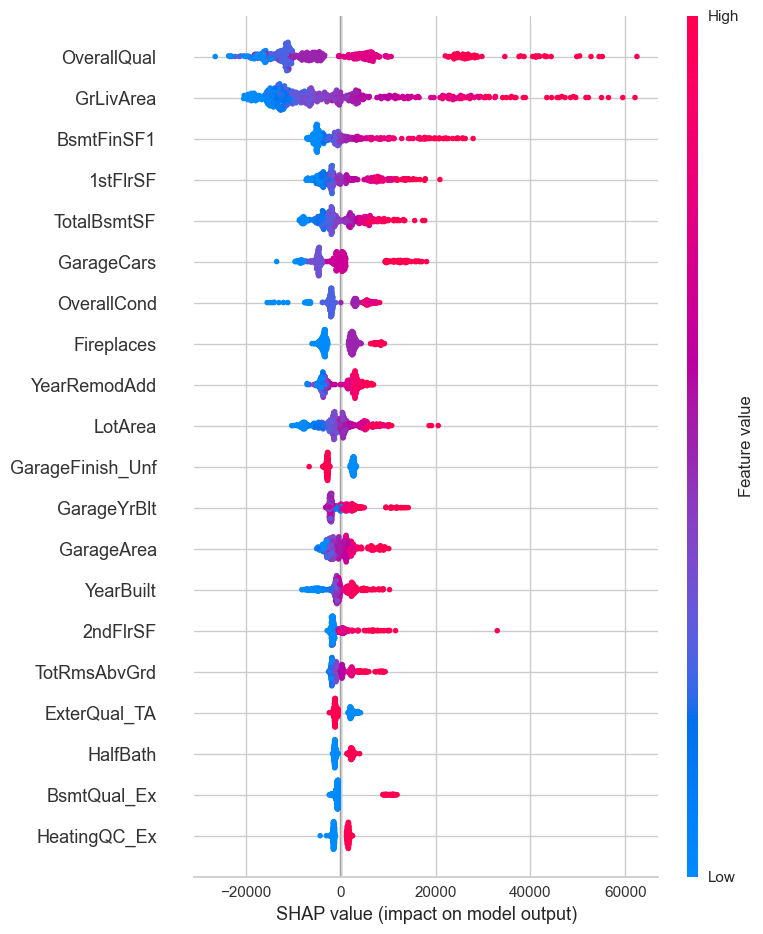

✅ SHAP summary plotted.


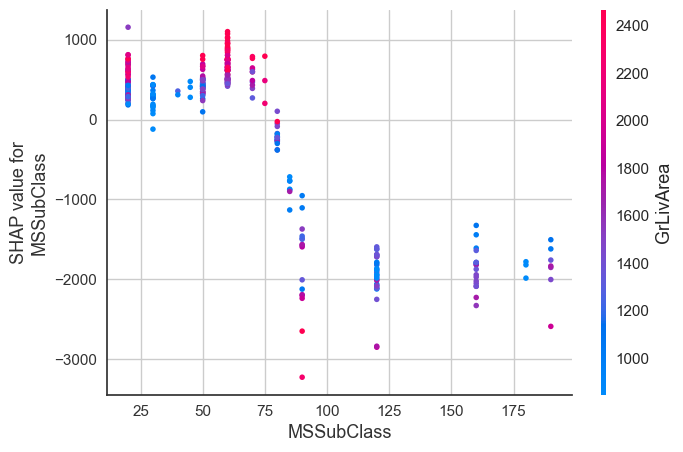

✅ SHAP correlation plotted.


✅ Local 'reason' plot for observation=0.


In [8]:
# Cell 7 — Model interpretability (SHAP)

from pycaret.regression import interpret_model

# Pick a model to explain: champion → tuned_best → best
model_to_explain = locals().get("champion") or locals().get("tuned_best") or locals().get("best")
assert model_to_explain is not None, "No model available to interpret. Run previous cells first."

print("Explaining model:", type(model_to_explain).__name__)

# 1) Global explanation — SHAP summary plot (requires `shap` and supported estimator)
try:
    interpret_model(model_to_explain, plot="summary")
    print("✅ SHAP summary plotted.")
except Exception as e:
    print("SHAP summary not available for this estimator/environment:", e)

# 2) Global relationships — SHAP correlation (feature interaction overview)
try:
    interpret_model(model_to_explain, plot="correlation")
    print("✅ SHAP correlation plotted.")
except Exception as e:
    print("SHAP correlation not available:", e)

# 3) Local explanation — why one specific prediction looks the way it does
# Use the first row of the transformed training data (index=0) for a 'reason' plot
try:
    interpret_model(model_to_explain, plot="reason", observation=0)
    print("✅ Local 'reason' plot for observation=0.")
except Exception as e:
    print("Local reason plot not available:", e)

# Notes:
# - If you get import errors, make sure `pip install shap` (already recommended).
# - Some linear/GLM models have limited SHAP support; tree-based boosters usually work best.


In [9]:
# Cell 8 — Finalize model & create Kaggle submission (predict on test.csv)

from pycaret.regression import finalize_model, predict_model, pull
import pandas as pd

# Choose the best available model handle
model = locals().get("champion") or locals().get("tuned_best") or locals().get("best")
assert model is not None, "No trained model found. Please run previous cells."

print("Finalizing model on full training data… (locks preprocessing + refits on all rows)")
final_model = finalize_model(model)
print("✅ Model finalized:", type(final_model).__name__)

# Inference on test.csv (unseen)
print("\nScoring test.csv …")
test_preds = predict_model(final_model, data=test)

# PyCaret returns a DataFrame with a 'prediction_label' column
pred_col = "prediction_label"
assert pred_col in test_preds.columns, "Expected 'prediction_label' in predictions."

# Build Kaggle submission file matching sample_submission format
SUB_PATH_OUT = "submission_pycaret.csv"
assert "Id" in test_preds.columns, "Expected 'Id' column in test set."

submission = pd.DataFrame({
    "Id": test_preds["Id"].astype(int),
    "SalePrice": test_preds[pred_col].astype(float)
})

submission.to_csv(SUB_PATH_OUT, index=False)
print(f"✅ Submission file written: {SUB_PATH_OUT}")
display(submission.head(10))

# (Optional) quick distribution sanity check
print("\nSubmission summary:")
display(submission["SalePrice"].describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]).to_frame().T)

# Next cell: persist the trained pipeline (save_model / load_model) and quick sanity predict.


Finalizing model on full training data… (locks preprocessing + refits on all rows)
✅ Model finalized: Pipeline

Scoring test.csv …


✅ Submission file written: submission_pycaret.csv


,Id,SalePrice
0,1461,126183.706092
1,1462,160206.146248
2,1463,186050.343005
3,1464,188952.538777
4,1465,186239.467807
5,1466,170777.681471
6,1467,171180.600356
7,1468,167276.112804
8,1469,186115.702911
9,1470,126903.672575



Submission summary:


,count,mean,std,min,1%,5%,50%,95%,99%,max
SalePrice,1459.0,178899.649667,76310.675714,40927.995062,63867.972598,93230.863463,157585.228198,335798.607142,445970.072266,530614.104153


In [10]:
# Cell 9 — Persist pipeline (save/load) & quick sanity prediction

from pycaret.regression import save_model, load_model, predict_model
import pandas as pd
import sys

SAVE_NAME = "pycaret_ames_champion"

# 1) Save the finalized pipeline (includes preprocessing + trained estimator)
save_path = save_model(final_model, SAVE_NAME)
print(f"✅ Saved pipeline to base name: {save_path}")

# 2) Load it back (simulates a fresh session)
loaded_model = load_model(SAVE_NAME)
print("✅ Reloaded pipeline:", type(loaded_model).__name__)

# 3) Sanity check inference on a small sample of test.csv
sample = test.head(5).copy()
sample_preds = predict_model(loaded_model, data=sample)

print("\nSanity predictions on test head(5):")
display(sample_preds[["Id", "prediction_label"]])

# 4) (Optional) Write a separate quick file for inspection
sample_preds[["Id", "prediction_label"]].rename(columns={"prediction_label": "SalePrice"}).to_csv(
    "sample_inference_preview.csv", index=False
)
print("📝 Wrote sample_inference_preview.csv")

# 5) Environment note
print("\nEnvironment:")
print("Python:", sys.version.split()[0])
try:
    import pycaret
    print("PyCaret:", pycaret.__version__)
except Exception:
    pass

# 🎉 End of core workflow (mirrors your original notebook): setup → compare → create/tune → ensemble/blend/stack → interpret → finalize → predict → save/load


Transformation Pipeline and Model Successfully Saved
✅ Saved pipeline to base name: (Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['MSSubClass', 'LotFrontage',
                                             'LotArea', 'OverallQual',
                                             'OverallCond', 'YearBuilt',
                                             'YearRemodAdd', 'MasVnrArea',
                                             'BsmtFinSF1', 'BsmtFinSF2',
                                             'BsmtUnfSF', 'TotalBsmtSF',
                                             '1stFlrSF', '2ndFlrSF',
                                             'LowQualFinSF', 'GrLivArea',
                                             'BsmtFullBath', 'BsmtHalfBath',
                                             'FullBath', 'HalfBath...
                                                                    'Exterior2nd',
                          


Sanity predictions on test head(5):


,Id,prediction_label
0,1461,126183.706092
1,1462,160206.146248
2,1463,186050.343005
3,1464,188952.538777
4,1465,186239.467807


📝 Wrote sample_inference_preview.csv

Environment:
Python: 3.11.14
PyCaret: 3.3.2
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2846
[LightGBM] [Info] Number of data points in the train set: 817, number of used features: 159
[LightGBM] [Info] Start training from score 182052.902081
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

In [13]:
# Cell 10 — (Optional) Interactive dashboard & config introspection

# 1) Try launching PyCaret's dashboard (may not be available in all environments)
#    This can open a new tab or inline app depending on the setup.
try:
    from pycaret.regression import dashboard

    model_for_dash = locals().get("champion") or locals().get("tuned_best") or locals().get("best")
    assert model_for_dash is not None, "No model available for dashboard."

    # Launch the dashboard (blocks while running in some environments).
    # Stop with Kernel Interrupt when done exploring.
    dashboard(model_for_dash)
except Exception as e:
    print("ℹ️ Dashboard not available or failed to start:", e)

# 2) Inspect key setup artifacts (useful for debugging / learning)
try:
    from pycaret.regression import get_config

    print("\n--- PyCaret config snapshot ---")
    X_train = get_config("X_train")
    X_test = get_config("X_test")
    y_train = get_config("y_train")
    y_test = get_config("y_test")
    prep_pipe = get_config("prep_pipe")
    pipeline = get_config("pipeline")

    print("X_train shape:", X_train.shape)
    print("X_test  shape:", X_test.shape)
    print("y_train length:", len(y_train))
    print("y_test  length:", len(y_test))

    print("\nPreprocessing pipeline steps:")
    try:
        for step_name, step_obj in prep_pipe.steps:
            print(" -", step_name, "=>", type(step_obj).__name__)
    except Exception:
        print(prep_pipe)

    print("\nFull pipeline (prep + model) tail:")
    try:
        for step_name, step_obj in pipeline.steps[-3:]:
            print(" -", step_name, "=>", type(step_obj).__name__)
    except Exception:
        print(pipeline)
except Exception as e:
    print("Could not retrieve config artifacts:", e)

# 3) (Optional) Export transformed matrices for external analysis
try:
    import pandas as pd
    Xy_train = X_train.copy()
    Xy_train[TARGET] = y_train.values
    Xy_test = X_test.copy()
    Xy_test[TARGET] = y_test.values

    Xy_train.to_csv("train_transformed.csv", index=False)
    Xy_test.to_csv("validation_transformed.csv", index=False)
    print("\n📝 Wrote 'train_transformed.csv' and 'validation_transformed.csv'")
except Exception as e:
    print("Skipping transformed export:", e)


ℹ️ Dashboard not available or failed to start: 
'explainerdashboard' is a soft dependency and not included in the pycaret installation. Please run: `pip install explainerdashboard` to install.
Alternately, you can install this by running `pip install pycaret[analysis]`

--- PyCaret config snapshot ---
Could not retrieve config artifacts: Variable 'prep_pipe' not found. Possible variables are: ['y_train_transformed', 'variables', 'n_jobs_param', 'exp_name_log', 'X_train', 'dataset_transformed', '_ml_usecase', 'variable_and_property_keys', 'data', 'y_train', 'X_train_transformed', 'y_transformed', 'train_transformed', 'html_param', 'gpu_param', 'X', 'memory', 'transform_target_param', '_available_plots', 'pipeline', 'fold_shuffle_param', 'train', 'USI', 'test_transformed', 'idx', 'X_transformed', 'X_test_transformed', 'fold_generator', 'fold_groups_param', 'X_test', 'y', 'log_plots_param', 'is_multiclass', 'gpu_n_jobs_param', 'y_test_transformed', 'seed', 'logging_param', 'target_param',